# Spatial and Temporal Analysis of California Temperature

## Overview

In this notebook, we will perform temporal and spatial analysis of monthly average temperatures in California to answer questions such as which parts of California are hotter, how temperatures have changed in recent years.


In [3]:
import numpy as np
import seaborn as sns 
from scipy import stats
import scipy
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import root_mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from geopandas import gpd
import os
import math
import warnings
warnings.filterwarnings('ignore')

## CA Climate Divisions

This project uses average temperature data from 6 climate divisions in California. More information on the US climate divisions is available at https://www.ncei.noaa.gov/access/monitoring/reference-maps/conus-climate-divisions. 
Before diving into the weather data, we will first get the geometry information for California's climate divisions as it will be used to create basemaps in this project.

**Dataset:** 
- US climate divisions dataset available at https://psl.noaa.gov/data/usclimdivs/boundaries.html. 
- This shapefile contains geometry information for each climate division in the United States.
- There is one record for each division with following information that is relevant to this project:
    - The geometry info is a polygon or a multipolygon of latitudes and longitudes marking the corresponding divisions's perimeter.
    - State field which will allow us to identify divisions in California.
- This is a public dataset available at the above mentioned NOAA website.

In [5]:
# Read the US Climate Divisions shapefile
clim_divs = gpd.read_file("../datasets/conus_climate_divisions/CONUS_CLIMATE_DIVISIONS.shp")
clim_divs.head(3)

,OBJECTID,STATE,STATE_FIPS,CD_2DIG,STATE_CODE,CLIMDIV,CD_NEW,FIPS_CD,NCDC_GEO_I,NAME,ST_ABBRV,SHAPE_AREA,SHAPE_LEN,geometry
0,91,New Mexico,35,05,29,2905,5,3505,1.0,CENTRAL VALLEY,NM,0.0,0.0,"POLYGON ((-105.878 33.244, -105.985 33.269, -1..."
1,92,New Mexico,35,06,29,2906,6,3506,2.0,CENTRAL HIGHLANDS,NM,0.0,0.0,"POLYGON ((-105.149 32.64, -105.223 32.563, -10..."
2,93,Idaho,16,01,10,1001,1,1601,3.0,PANHANDLE,ID,0.0,0.0,"POLYGON ((-116.04882 47.97673, -116.118 48.033..."


In [6]:
# Filter California divisions as identified by STATE and drop columns that are not needed
ca_divisions = clim_divs[clim_divs["STATE"] == "California"][["NAME", "geometry"]]
ca_divisions.reset_index(inplace = True, drop=True)
ca_divisions.rename(columns={"NAME": "division"}, inplace=True)
ca_divisions["lat"] = ca_divisions["geometry"].centroid.y
ca_divisions["lon"] = ca_divisions["geometry"].centroid.x
# Use user friendly division names
div_name_map = {"SOUTHEAST DESERT BASIN" : "South East Desert", "NORTHEAST INTER. BASINS" :  "North East",
                "SACRAMENTO DRNG." : "Sacramento Division", "SAN JOAQUIN DRNG." : "San Joaquin Division",
                "NORTH COAST DRAINAGE" : "North Coast", "CENTRAL COAST DRNG." : "Central Coast",
                "SOUTH COAST DRNG.": "South Coast"}
ca_divisions["division"] = ca_divisions["division"].map(div_name_map)
ca_divisions.set_index("division", inplace=True)
ca_divisions

,geometry,lat,lon
division,,,
South East Desert,"POLYGON ((-118.1847 37.72055, -118.15074 37.69...",34.981015,-116.515220
North East,"POLYGON ((-119.99917 41.99454, -119.99933 41.9...",39.755291,-119.979706
Sacramento Division,"POLYGON ((-120.20555 41.99339, -120.18874 41.9...",39.950522,-121.552349
San Joaquin Division,"POLYGON ((-120.54465 38.75647, -120.52909 38.7...",36.824921,-119.794426
North Coast,"MULTIPOLYGON (((-122.37819 42.00952, -122.3761...",40.519338,-123.045852
Central Coast,"MULTIPOLYGON (((-121.84418 38.05694, -121.8369...",36.501342,-121.315738
South Coast,"MULTIPOLYGON (((-120.25608 35.21254, -120.2474...",34.018155,-118.263328


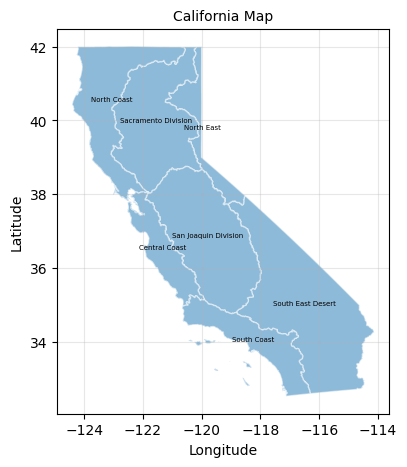

In [7]:
# This data will be used as base map for spatial maps in this project; verify it is correct
ax = ca_divisions.plot(figsize=(15,5), edgecolor="white", alpha=0.5)
ax.set_title("California Map", fontsize=10)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(alpha=0.3)
ca_divisions.apply(lambda row: ax.text(row["lon"], row["lat"], row.name,
                                       fontsize=5, ha='center', color='black'), axis=1)
plt.show();

<font color="purple"> <font size=4> Visual inspection of above plot confirms that ca_divisions has correct geometry for the state of California. </font>

## California Climate Division Weather Data

**California Weather Data:**
- Monthly average temperatures from 1895 to 2025 for all California divisons shown in the above map except for the North East Basin.
    - We will skip the North East basin because it is relatively very small in size.
- Data is in CSV format.
- Each division has a seperate CSV file. So total 6 CSV files for the 6 divisions.
- Each CSV file has:

      - 131 rows: one for each year from 1895 to 2025
      - 13 columns: 12 columns for each month and a column for year.
- Temperatures are in tenths of deg. Fahrenheit.  ie.  -35 = -3.5 F,  557 = 55.7 F
- Link to the data: From https://calclim.dri.edu/pages/tools.html follow the US Divisional Climate Data (http://www.wrcc.dri.edu/spi/divplot2map.html) link.
- This is a publicly available data from Calclim which is a joint venture of the Western Regional Climate Center and the Scripps Institution of Oceanography.
- Dataset used in this project is also availabe [here](https://github.com/dpoonam/AI-ML-DataScience/tree/main/GeoScience/datasets/weather_CA_divisions_1895_2025).

In [10]:
# Seperate file for each division
# Therefore, total 6 files for 6 divisions
# Checkout a sample file 
pd.read_csv("../datasets/weather_CA_divisions_1895_2025/Central Coast/avg_temp_ccd - avg_temp_CCD.csv").head(3)

,Year,Jan.,Feb.,Mar.,Apr.,May,Jun.,Jul.,Aug.,Sep.,Oct.,Nov.,Dec.
0,1895,459,495,498,534,590,645,667,668,634,603,503,449
1,1896,490,500,516,490,561,648,673,672,624,604,494,495
2,1897,459,469,459,561,606,653,687,690,656,576,508,461


In [11]:
# Helper function to read and combine data for the user specified climate variable for all CA divisions
def combine_ca_division_weather_data(variable, title, ylabel, data_dir):
    all_divisions = pd.DataFrame()
    for subdir in os.listdir(data_dir):
        subdir_p = os.path.join(data_dir, subdir)
        if os.path.isdir(subdir_p):
            division = subdir
            #print("CA Division: ", division)
            for file_name in os.listdir(subdir_p):
                if variable in file_name and file_name.endswith('.csv'):
                    file_path = os.path.join(subdir_p, file_name)
                    df = pd.read_csv(file_path)
                    
                    # Transform the dataframe from a wide format to a long format
                    df.rename(columns={'Year': 'year'}, inplace=True)
                    df = pd.melt(df, id_vars=["year"], var_name="month", value_name=division)
                    df["month"] = df["month"].str.replace('.', '', regex=False)
                    df["date"] = pd.to_datetime(df["month"] + '-' + df["year"].astype(str), format='%b-%Y')
                    df = df.set_index("date").sort_index()
 
                    # Temperature in tenths of deg. Fahrenheit.  ie.  -35 = -3.5 F,  557 = 55.7 F
                    df[division] = df[division]/10
                
                    if all_divisions.empty:
                        all_divisions = df.copy()
                    else:
                        # Do not include year and month columns for subsequent divisions
                        all_divisions = pd.concat([all_divisions, df[[division]]], axis=1)
                        
    return all_divisions

In [12]:
# Read avg temp data for all 6 CA divisions and combine them into one dataframe
ca_avg_temps = combine_ca_division_weather_data("avg_temp", "Annual Average Temperature", "Temperature (F)",
                                                "../datasets/weather_CA_divisions_1895_2025/")

ca_avg_temps.head()

,year,month,South East Desert,South Coast,North Coast,Central Coast,Sacramento Division,San Joaquin Division
date,,,,,,,,
1895-01-01,1895,Jan,43.6,45.7,37.9,45.9,37.4,39.7
1895-02-01,1895,Feb,50.4,50.0,43.0,49.5,43.5,44.6
1895-03-01,1895,Mar,53.8,49.9,43.6,49.8,45.1,45.8
1895-04-01,1895,Apr,61.0,53.8,48.3,53.4,51.1,51.8
1895-05-01,1895,May,70.7,61.4,53.5,59.0,57.6,59.7


In [13]:
ca_avg_temps.tail(2)

,year,month,South East Desert,South Coast,North Coast,Central Coast,Sacramento Division,San Joaquin Division
date,,,,,,,,
2025-11-01,2025,Nov,999.9,999.9,999.9,999.9,999.9,999.9
2025-12-01,2025,Dec,999.9,999.9,999.9,999.9,999.9,999.9


In [14]:
ca_avg_temps.shape

(1572, 8)

### Data Cleanup

In [16]:
# Display rows that have missing data (values set to 999.9)
ca_avg_temps[(ca_avg_temps == 999.9).any(axis=1)]

,year,month,South East Desert,South Coast,North Coast,Central Coast,Sacramento Division,San Joaquin Division
date,,,,,,,,
2025-02-01,2025,Feb,999.9,999.9,999.9,999.9,999.9,999.9
2025-03-01,2025,Mar,999.9,999.9,999.9,999.9,999.9,999.9
2025-04-01,2025,Apr,999.9,999.9,999.9,999.9,999.9,999.9
2025-05-01,2025,May,999.9,999.9,999.9,999.9,999.9,999.9
2025-06-01,2025,Jun,999.9,999.9,999.9,999.9,999.9,999.9
2025-07-01,2025,Jul,999.9,999.9,999.9,999.9,999.9,999.9
2025-08-01,2025,Aug,999.9,999.9,999.9,999.9,999.9,999.9
2025-09-01,2025,Sep,999.9,999.9,999.9,999.9,999.9,999.9
2025-10-01,2025,Oct,999.9,999.9,999.9,999.9,999.9,999.9


In [17]:
# Data for Feb to Dec 2025 is not available hence the values are set to 999.9 
# Remove all data for 2025
ca_avg_temps = ca_avg_temps[ca_avg_temps["year"] < 2025]
ca_avg_temps.tail(3)

,year,month,South East Desert,South Coast,North Coast,Central Coast,Sacramento Division,San Joaquin Division
date,,,,,,,,
2024-10-01,2024,Oct,72.8,67.6,58.4,67.1,61.1,65.6
2024-11-01,2024,Nov,52.8,54.8,43.2,52.0,43.9,48.0
2024-12-01,2024,Dec,52.8,55.0,43.7,52.6,44.0,47.7


In [18]:
# Check for NaNs
ca_avg_temps.isna().sum()

year                    0
month                   0
South East Desert       0
South Coast             0
North Coast             0
Central Coast           0
Sacramento Division     0
San Joaquin Division    0
dtype: int64

In [19]:
ca_avg_temps.shape

(1560, 8)

In [20]:
# Check for gaps in the data

# Expected number of entries
start_year = int(ca_avg_temps["year"].min())
end_year = int(ca_avg_temps["year"].max())
expected_num_rows = (end_year - start_year + 1) * 12
if ca_avg_temps.shape[0] != expected_num_rows:
    print("Some years have gaps in data. Expected number of entries:{}, Actual:{}".format(expected_num_rows, ca_avg_temps.shape[0]))
else:
    print("No gaps in the data")

No gaps in the data


### Exploratory Data Analysis

#### Statistical Analysis

In [23]:
divs = [x for x in list(ca_avg_temps.columns) if x not in ["year", "month"]]
ca_avg_temps[divs].describe()

,South East Desert,South Coast,North Coast,Central Coast,Sacramento Division,San Joaquin Division
count,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000
mean,64.449038,59.350641,52.030705,57.579487,54.208462,56.951795
std,13.976040,8.584691,10.185219,8.220549,11.884585,11.743306
min,34.300000,38.700000,29.600000,38.500000,27.600000,32.600000
25%,51.500000,51.975000,42.900000,50.200000,43.400000,46.375000
50%,63.800000,58.350000,50.800000,56.850000,53.300000,56.000000
75%,77.700000,67.400000,61.500000,65.600000,65.300000,68.125000
max,91.600000,77.600000,74.100000,75.000000,79.200000,81.100000


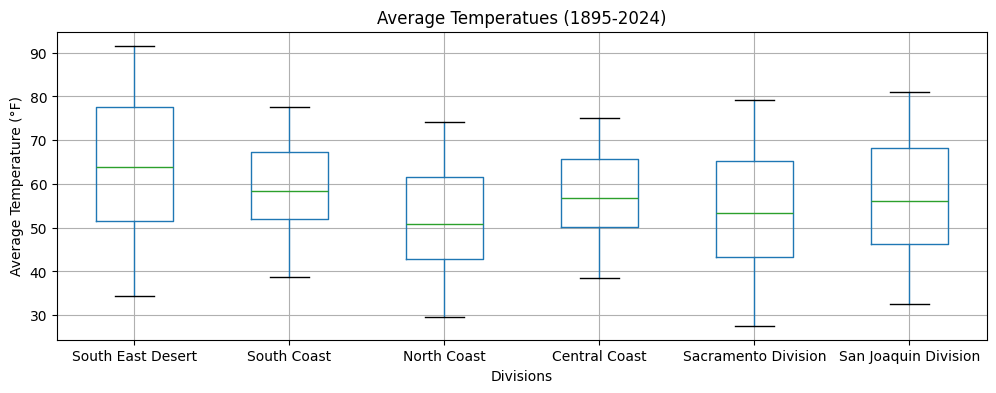

In [24]:
years_str = " (" + str(start_year) + "-" + str(end_year) + ")"
temp_ylabel = "Average Temperature (°F)"
ca_avg_temps[divs].boxplot(figsize=(12,4))
plt.title("Average Temperatues" + years_str)
plt.ylabel(temp_ylabel)
plt.xlabel("Divisions")
plt.show();

<font color="purple"> <font size=3> - The descriptive statistics and the box plots indicate that the South East Desert and South Coast have slightly higher mean and median temperatures compared to those in the other divisions. This makes sense as these divisions are in Southern California which is relatively hotter.  <font>

<font color="purple"> <font size=3> - The South East Desert is hottest, has large range and high max which is typical for desert climate. </font>

<font color="purple"> <font size=3> - The North Coast is the coolest region on average which makes sense based on the geography of California. </font>

#### Temporal and Spatial Analysis

In [27]:
# Get yearly average temps per division
ca_temp_by_year = ca_avg_temps.groupby("year")[divs].mean()
ca_temp_by_year.head(3)

,South East Desert,South Coast,North Coast,Central Coast,Sacramento Division,San Joaquin Division
year,,,,,,
1895,63.191667,57.816667,51.083333,56.208333,53.608333,55.075000
1896,64.791667,59.075000,51.583333,56.391667,54.425000,55.975000
1897,63.000000,57.675000,51.191667,56.541667,53.541667,55.383333


In [28]:
# Helper function for linear regression
def linear_regression(x, y, show_eval_metrics=True):
    x2 = sm.add_constant(x)
    model_lr = sm.OLS(y,x2).fit()
    y_pred = model_lr.fittedvalues

    if show_eval_metrics:
        print("Linear regression model summary:\n", model_lr.summary())
        print("R^2: ", model_lr.rsquared)
        rmse_err = root_mean_squared_error(y, y_pred)
        print("RMSE: ",rmse_err)
    
    return y_pred

# Helper function to plot data
def plot_ca_div_data(data, title, plot_linear_regression=False, col="avg_temp", figsize=(12,4)):
    if plot_linear_regression:
        # Draw linear regression line with time (year) as the predictor
        t = 1 + (data["year"] - data["year"][0])
        data_lr = np.squeeze(data[col])
        y_pred = linear_regression(t, data_lr, show_eval_metrics=False)
        plt.figure(figsize=figsize)
        plt.plot(data["year"], data_lr, label=col, linewidth=3)
        plt.plot(data["year"], y_pred, "r--", label="Linear Regression Trend Line", linewidth=2)
    else:
        data.plot(grid=True, figsize=figsize, fontsize=15)
    plt.xlabel("Year", fontsize=10)
    plt.ylabel(temp_ylabel, fontsize=10)
    plt.title(title, fontsize=15)
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.grid(True)
    ax = plt.gca()
    ax.ticklabel_format(style='plain', axis='y', useOffset=False)
    plt.show();


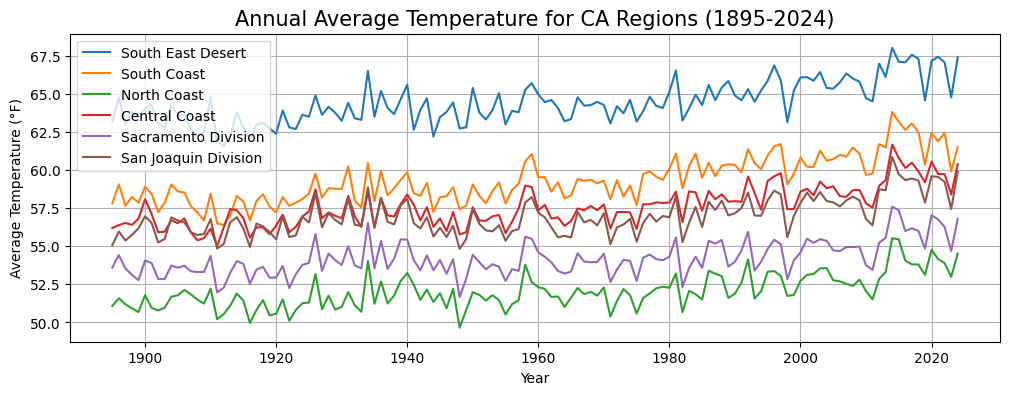

In [29]:
# Plot yearly avg temps per division
plot_ca_div_data(ca_temp_by_year, "Annual Average Temperature for CA Regions" + years_str)

<font color="purple"> <font size=3> As reflected in the descriptive statistics and box plots, the annual average temperature plot also shows that the South East Desert and South Coast regions of Southern California tend to be relatively hotter.  <font>

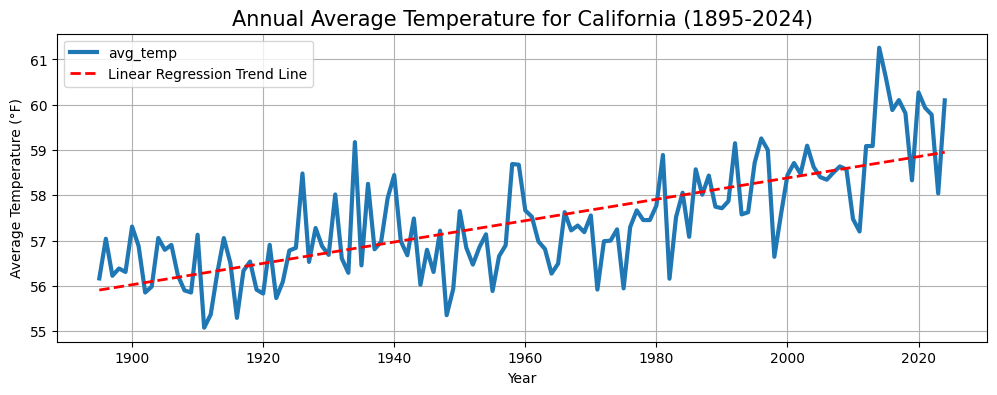

In [31]:
# Plot yearly avg temps for the state of California
plot_ca_div_data(ca_temp_by_year.mean(axis=1).reset_index(name='avg_temp'), 
                 "Annual Average Temperature for California" + years_str, plot_linear_regression=True)

<font color="purple"> <font size=3> The annual average temperature plot indicates a rising trend in California's average temperature over the years, as demonstrated by the linear regression trend line. <font>

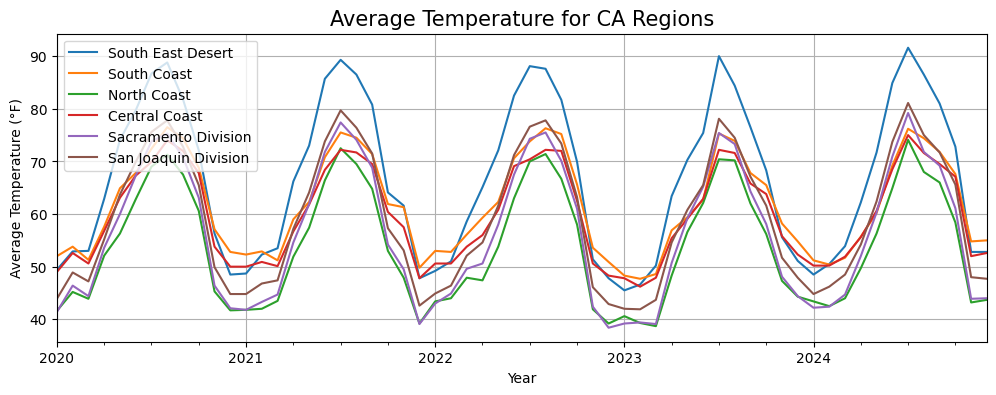

In [33]:
# Plot temps for last 5 years
plot_ca_div_data(ca_avg_temps[ca_avg_temps["year"] > (end_year-5)][divs] , 
                 "Average Temperature for CA Regions")

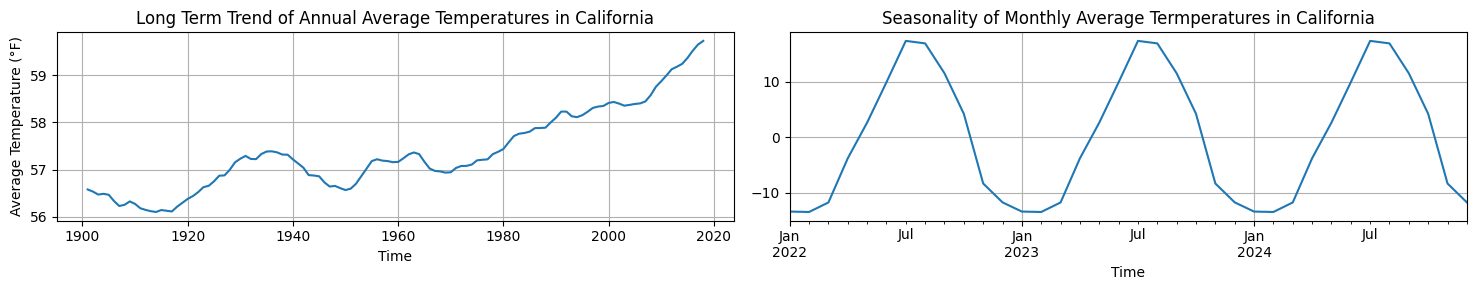

In [34]:
# Decompose and plot various characteristics of the temperature time series
fig, axes = plt.subplots(1,2, figsize=(15,3))
# Use annual averages to see the long term trend
decomp = seasonal_decompose(ca_temp_by_year.mean(axis=1), model='additive', period=12)
decomp.trend.plot(ax=axes[0], title="Long Term Trend of Annual Average Temperatures in California", grid=True, ylabel=temp_ylabel, 
                  xlabel="Time")

# Use monthly averages for last 3 years to see the seasonality
ca_temp_all_divs = ca_avg_temps[divs].mean(axis=1)
decomp = seasonal_decompose(ca_temp_all_divs[ca_temp_all_divs.index.year > (end_year - 3)], model='additive', period=12)
decomp.seasonal.plot(ax=axes[1], title="Seasonality of Monthly Average Termperatures in California", grid=True, xlabel="Time")

plt.tight_layout()
plt.show();

<font color="purple"> <font size=3> The plot shows a seasonal pattern in monthly average temperatures, as expected, along with a noticeable upward trend in California’s annual average temperatures, particularly since the 1970s.</font>

In [36]:
# Compare pre-1970s and recent monthly average temperatures to see whether the seasonal characteristics have changed
def plot_monthly_averages(data_to_plot, title, ax):
    # Group data by month, calculate monthly average for each division and take a mean across all divisions to find
    # the monthly averages for the state of California
    ca_temp_by_month = data_to_plot.groupby("month")[divs].mean().mean(axis=1).reset_index(name="avg_temp")
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ca_temp_by_month['month'] = pd.Categorical(ca_temp_by_month['month'], categories=month_order, ordered=True)
    ca_temp_by_month = ca_temp_by_month.sort_values('month')
    ca_temp_by_month.reset_index(inplace=True, drop=True)
    bars = ax.bar(ca_temp_by_month["month"], ca_temp_by_month["avg_temp"])
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.1f}°F", ha='center', va='bottom', fontsize=8)
    ax.set_xlabel("Month", fontsize=7)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.legend(fontsize=5)
    ax.set_ylabel(temp_ylabel, fontsize=7)
    ax.set_title(title, fontsize=10)
    ax.grid(True, alpha=0.3)


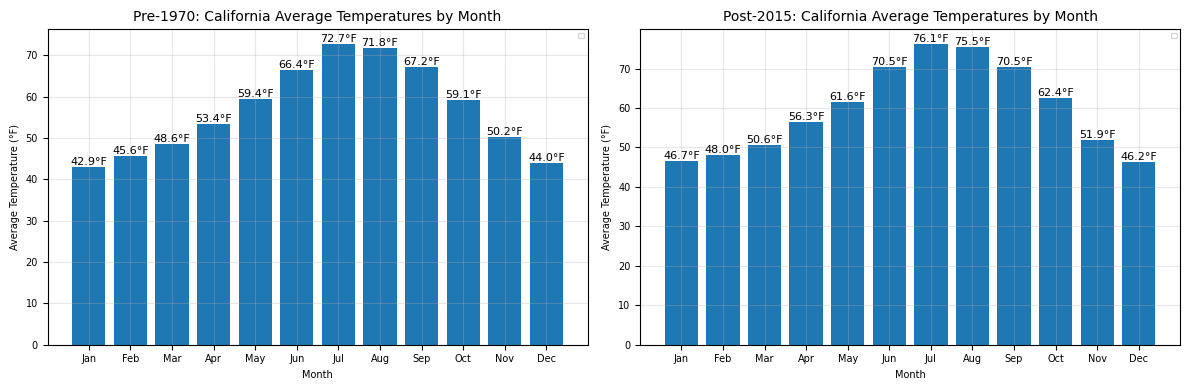

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_monthly_averages(ca_avg_temps[ca_avg_temps["year"] < 1970], "Pre-1970: California Average Temperatures by Month", axes[0])
plot_monthly_averages(ca_avg_temps[ca_avg_temps["year"] >= 2015], "Post-2015: California Average Temperatures by Month", axes[1])
plt.tight_layout()
plt.show();

<font color="purple"> <font size=3>
The plot shows that, over the past decade, monthly average temperatures are approximately 2°F to 4°F higher than the monthly averages recorded before 1970. </font>

In [39]:
# Plot a map of annual average temp for spatial analysis
# Use average temperature for the last year
temps = ca_temp_by_year[ca_temp_by_year.index == end_year].transpose().reset_index()
temp_col = "avg_temp_" + str(end_year)
temps.columns = ["division", temp_col]
temps.set_index("division", inplace=True)

ca_geo_temps = ca_divisions.copy()
ca_geo_temps[temp_col] = temps[temp_col]
ca_geo_temps.dropna(inplace=True)
ca_geo_temps

,geometry,lat,lon,avg_temp_2024
division,,,,
South East Desert,"POLYGON ((-118.1847 37.72055, -118.15074 37.69...",34.981015,-116.515220,67.433333
Sacramento Division,"POLYGON ((-120.20555 41.99339, -120.18874 41.9...",39.950522,-121.552349,56.808333
San Joaquin Division,"POLYGON ((-120.54465 38.75647, -120.52909 38.7...",36.824921,-119.794426,59.908333
North Coast,"MULTIPOLYGON (((-122.37819 42.00952, -122.3761...",40.519338,-123.045852,54.516667
Central Coast,"MULTIPOLYGON (((-121.84418 38.05694, -121.8369...",36.501342,-121.315738,60.400000
South Coast,"MULTIPOLYGON (((-120.25608 35.21254, -120.2474...",34.018155,-118.263328,61.516667


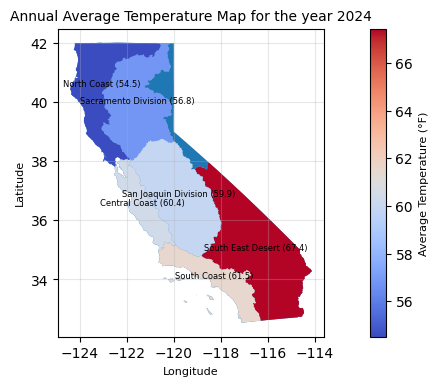

In [40]:
def plot_temps(data_to_plot, title, col):
    fig, ax = plt.subplots(figsize=(12, 4))
    ca_divisions.plot(ax=ax,  edgecolor="none", linewidth=0.8)
    data_to_plot.plot(ax=ax, column=col, legend=True, edgecolor = "none", cmap="coolwarm")
    data_to_plot.apply(lambda row: ax.text(row["lon"], row["lat"], row.name + " (" + f"{row[col]:.1f}" + ")",
                                fontsize=6, ha='center', color='black'), axis=1)
    # The last axis added is the colorbar
    cbar_ax = fig.axes[-1]
    cbar_ax.set_ylabel(temp_ylabel, fontsize=8)
    ax.set_title(title, fontsize=10)
    plt.xlabel("Longitude", fontsize=8)
    plt.ylabel("Latitude", fontsize=8)
    ax.grid(alpha=0.3)
    plt.show();

plot_temps(ca_geo_temps, "Annual Average Temperature Map for the year " + str(end_year), temp_col)

<font color="purple"> <font size=3> The temperature map shows that the South East Desert experienced the highest average temperatures last year, followed by the South Coast. Temperatures generally declined moving northward toward higher latitudes.  </font>

## Conclusions

- The South East Desert and South Coast located in the Southern California are relatively hotter compared to the regions in the Northern California. <font>

- There has been an uptrend in California's monthly average temperatures particularly since the 1970s. <font>

- Over the past decade, monthly average temperatures are approximately 2°F to 4°F higher than the monthly averages recorded before 1970. 
